## Imports

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import sys
X2B8_DIR = '../x2b8_optimization_code'
sys.path.append(X2B8_DIR)

import pandas as pd
pd.set_option('display.max_columns', None)
from imputation import Imputer
from preprocessing import Preprocessor
from model_training import ModelTrainer
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as font_manager
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, \
f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, \
average_precision_score
import seaborn as sns
import random
import tensorflow as tf

## Direct methods from main.py

In [2]:
def set_seed(seed_value):
    np.random.seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    tf.random.set_seed(seed_value)
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

SEED = 42
set_seed(SEED)

def run_models_and_collect_results(model_types, imputation_methods, hyperparams, print_args):
    all_results = []
    prediction_data = {}
    valid_models = ['XGBoost', 'XGBoostMinusGCSVerbal', 'XGBoostTopTen', 'RNN', 'LSTM', 'LightGBM', 'RandomForest', 'LogisticRegression']
    valid_imputations = ['binning', 'mean', 'raw']
    
    for model_type in model_types:
        if model_type not in valid_models:
            print("Unrecognizable model:", model_type)
            continue

        for method in imputation_methods:
            if method not in valid_imputations:
                print("Unrecognizable imputation method:", method)
                continue

            if (model_type in ['RNN', 'LSTM', 'RandomForest', 'LogisticRegression'] and method == 'raw') or \
               (model_type in ['XGBoostMinusGCSVerbal', 'XGBoostTopTen'] and method in ['binning', 'mean']):
                continue

            train_data, val_data, test_data = load_data()
            print(f"Running for model: {model_type} with imputation method: {method}")

            tf.keras.backend.clear_session()
            set_seed(SEED)

            metric_results, y_true, preds_proba, X_train, X_val, X_test, model, model_type = ModelTrainer.run_model(
                train_data, val_data, test_data, model_type, method, hyperparams, print_args)
            
            result_dict = {
                'Model_Type': model_type,
                'Imputation_Method': method,
            }
            
            result_dict.update(metric_results)
            all_results.append(result_dict)

            prediction_key = f"{model_type}_{method}"
            prediction_data[prediction_key] = {'y_true': y_true, 'y_preds_proba': preds_proba}

    return pd.DataFrame(all_results), prediction_data

def plot_metrics(ax_roc, ax_pr, y_true, y_preds_proba, label, color):
    y_preds_proba = np.ravel(y_preds_proba)
    y_true = np.ravel(y_true)

    arial_font = font_manager.FontProperties(family='Arial', size=18)
    arial_font_legend = font_manager.FontProperties(family='Arial', size=12)
    fpr, tpr, _ = roc_curve(y_true, y_preds_proba)
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.4f})')

    y_true_minority = np.where(y_true == 1, 0, 1)
    y_preds_proba_minority = 1 - y_preds_proba
    precision_minority, recall_minority, _ = precision_recall_curve(y_true_minority, y_preds_proba_minority)
    average_precision_minority = average_precision_score(y_true_minority, y_preds_proba_minority)
    ax_pr.plot(
        recall_minority, precision_minority, color=color, lw=2, label=f'{label} Minority (AP = {average_precision_minority:.4f})')

    ax_roc.set_title('Receiver Operating Characteristic', fontproperties=arial_font)
    ax_roc.set_xlabel('False Positive Rate (1-Specificity)', fontproperties=arial_font)
    ax_roc.set_ylabel('True Positive Rate (Sensitivity)', fontproperties=arial_font)
    
    ax_pr.set_title('Precision-Recall Curve', fontproperties=arial_font)
    ax_pr.set_xlabel('Recall (Sensitivity)', fontproperties=arial_font)
    ax_pr.set_ylabel('Precision (Positive predictive value)', fontproperties=arial_font)
    
    ax_roc.legend(loc="lower right", prop=arial_font_legend)
    ax_pr.legend(loc="best", prop=arial_font_legend)
    return fpr, tpr, roc_auc

def plot_all_metrics(results_df, prediction_data):
    fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(20, 6))
    arial_font = font_manager.FontProperties(family='Arial', size=18)
    arial_font_legend = font_manager.FontProperties(family='Arial', size=12)
    color_cycle = ['#4C78A8', '#F58518', '#E45756', '#72B7B2', '#54A24B',
                     '#ECAE8A', '#FF9DA6', '#9D755D', '#BAB0AC', '#9C755F']

    lines_roc, lines_pr = [], []

    for i, (key, data) in enumerate(prediction_data.items()):
        y_true = data['y_true']
        y_preds_proba = data['y_preds_proba']
        label = key.replace('_', ' + ')
        color = color_cycle[i % len(color_cycle)]
        # print(f"Plotting {label} with color {color}")
        unique, counts = np.unique(y_preds_proba, return_counts=True)
        # print("Unique predicted probabilities and their counts:")
        # print(np.asarray((unique, counts)).T)
        y_true = np.array(y_true)
        y_true_minority = np.where(y_true == 0, 1, 0)
        y_preds_proba_minority = 1 - y_preds_proba

        plot_metrics(ax_roc, ax_pr, y_true, y_preds_proba, label, color)

        line_roc = ax_roc.get_lines()[-1]
        auc_value = roc_auc_score(y_true, y_preds_proba)
        lines_roc.append((line_roc, f'{label} (AUC = {auc_value:.4f})'))

        ap_value_minority = average_precision_score(y_true_minority, y_preds_proba_minority)
        lines_pr.append((ax_pr.get_lines()[-1], f'{label} (AP = {ap_value_minority:.4f})'))
        fpr, tpr, roc_auc = plot_metrics(ax_roc, ax_pr, y_true, y_preds_proba, label, color)
        
        ax_roc.set_xlim([min(fpr) - 0.05, max(fpr) + 0.05])
        ax_roc.set_ylim([min(tpr) - 0.05, max(tpr) + 0.05])

        ax_pr.set_xlim([-0.05, 1.05])
        ax_pr.set_ylim([-0.05, 1.05])


    _, _, test_data = load_data()
    test_data

    minority_class_proportion = test_data['labels'].value_counts(normalize=True).get(0, 1)
    print("minority_class_proportion", minority_class_proportion)

    baseline_roc_line, = ax_roc.plot(
        [0, 1], [0, 1], color='black', lw=1, linestyle='--', label='Baseline (data balance - no skill)')
    baseline_pr_line = ax_pr.axhline(
        y=minority_class_proportion, color='black', lw=1, linestyle='--', label='Baseline (minority class proportion)')

    lines_roc.append((baseline_roc_line, 'Baseline (data balance - no skill)'))
    lines_roc.sort(
        key=lambda x: (
            x[1].lower() == 'baseline (data balance - no skill)',
            -float(x[1].split('= ')[-1].rstrip(')')) if 'auc' in x[1].lower() else 0))
    sorted_lines_roc, sorted_labels_roc = zip(*lines_roc)

    lines_pr.sort(key=lambda x: float(x[1].split('= ')[-1].rstrip(')')), reverse=True)
    lines_pr.append((baseline_pr_line, 'Baseline (data balance - no skill)'))
    sorted_lines_pr, sorted_labels_pr = zip(*lines_pr)

    ax_roc.set_title('Receiver Operating Characteristic', fontproperties=arial_font)
    ax_roc.set_xlabel('False Positive Rate (1-Specificity)', fontproperties=arial_font)
    ax_roc.set_ylabel('True Positive Rate (Sensitivity)', fontproperties=arial_font)

    ax_pr.set_title('Precision-Recall Curve', fontproperties=arial_font)
    ax_pr.set_xlabel('Recall (Sensitivity)', fontproperties=arial_font)
    ax_pr.set_ylabel('Precision (Positive predictive value)', fontproperties=arial_font)

    ax_roc.legend(sorted_lines_roc, sorted_labels_roc, loc="lower right", prop=arial_font_legend)
    ax_pr.legend(sorted_lines_pr, sorted_labels_pr, loc="best", prop=arial_font_legend)

    plt.show()
    return

## Read in data

In [3]:
DATA_DIR = '../../../CarpeDiem Extubation Prediction Sam Alec/data'
EDW_DIR = f"{DATA_DIR}/edw_redacted"
CDH_DIR = f"{DATA_DIR}/cdh_redacted"

In [4]:
auto_train = pd.read_csv(f'{EDW_DIR}/train.csv',index_col=0)
auto_val = pd.read_csv(f'{EDW_DIR}/val.csv',index_col=0)
auto_test = pd.read_csv(f'{EDW_DIR}/test.csv',index_col=0)
auto_fail = pd.read_csv(f'{EDW_DIR}/fail.csv',index_col=0)

In [5]:
cdh_full = pd.read_csv(f'{CDH_DIR}/full.csv',index_col=0)
cdh_trach = pd.read_csv(f'{CDH_DIR}/trach.csv',index_col=0)
cdh_fail = pd.read_csv(f'{CDH_DIR}/fail.csv',index_col=0)

In [7]:
np.all(auto_train.columns == cdh_full.columns)

True

## Run table script for optimized models

In [8]:
def load_data():
    train_data = pd.read_csv(f'{EDW_DIR}/train.csv', index_col=0)
    val_data = pd.read_csv(f'{EDW_DIR}/val.csv', index_col=0)
    test_data = pd.read_csv(f'{EDW_DIR}/test.csv', index_col=0)
    return train_data, val_data, test_data

In [10]:
model_types = ['RNN','LSTM','LightGBM','LogisticRegression']
imputation_methods = ['binning','mean','raw']


hyperparams = {
    'LSTM_binning':{'learning_rate':0.01,'layer_1_size':128,'layer_2_size':64,'batch_size':32,'epochs':100},
    'RNN_binning':{'learning_rate':0.01,'layer_1_size':64,'layer_2_size':16,'batch_size':32,'epochs':100},
    'LightGBM_binning':{'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 127},
    'LightGBM_raw':{'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 127},
    'LogisticRegression_binning':{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
}

# just remove non-optimized models that pass through from the results file
for m in model_types:
    for i in imputation_methods:
        run = f"{m}_{i}"
        if run not in hyperparams.keys():
            if m in ['LSTM','RNN']:
                hyperparams[run] = hyperparams['LSTM_binning']
            elif m == 'LightGBM':
                hyperparams[run] = hyperparams['LightGBM_binning']
            elif m == 'LogisticRegression':
                hyperparams[run] = hyperparams['LogisticRegression_binning']
            else:
                print('Unknown')


print_args = {
    'training':False,
    'model_architecture':False,
    'feature_importance_masking':False,
    'run_feature_importance':False,
    'save_shap':False
}

results_df, prediction_data = run_models_and_collect_results(model_types, imputation_methods, hyperparams, print_args)

Running for model: RNN with imputation method: binning
Threshold 0.9098939929328622
AUC for RNN: 0.869 (0.836, 0.899)
Running for model: RNN with imputation method: mean
Threshold 0.9098939929328622
AUC for RNN: 0.581 (0.505, 0.651)
Running for model: LSTM with imputation method: binning
Threshold 0.9098939929328622
AUC for LSTM: 0.870 (0.834, 0.902)
Running for model: LSTM with imputation method: mean
Threshold 0.9098939929328622
AUC for LSTM: 0.628 (0.558, 0.697)
Running for model: LightGBM with imputation method: binning
Threshold 0.9098939929328622
AUC for LightGBM: 0.834 (0.785, 0.874)
Running for model: LightGBM with imputation method: mean
Threshold 0.9098939929328622
AUC for LightGBM: 0.827 (0.777, 0.870)
Running for model: LightGBM with imputation method: raw
Threshold 0.9098939929328622
AUC for LightGBM: 0.833 (0.791, 0.871)
Running for model: LogisticRegression with imputation method: binning
Threshold 0.9098939929328622
AUC for LogisticRegression: 0.859 (0.820, 0.897)
Runni

Remove models that weren't optimized

In [11]:
results_df = results_df.loc[[0,2,4,6,7],:]

In [12]:
keys_to_keep = ['LSTM_binning', 'RNN_binning', 'LightGBM_binning', 'LightGBM_raw', 'LogisticRegression_binning']

In [13]:
prediction_data = dict(filter(lambda item: item[0] in keys_to_keep, prediction_data.items()))

In [15]:
results_df

,Model_Type,Imputation_Method,AUC,AUPRC,Overall Accuracy,F1 Score Class 0,F1 Score Class 1,Precision Class 0,Precision Class 1,Recall Class 0,Recall Class 1
0,RNN,binning,"0.869 (0.836, 0.899)","0.295 (0.208, 0.387)","0.701 (0.669, 0.733)","0.331 (0.272, 0.393)","0.807 (0.782, 0.831)","0.201 (0.160, 0.247)","0.994 (0.987, 1.000)","0.953 (0.895, 1.000)","0.679 (0.645, 0.714)"
2,LSTM,binning,"0.870 (0.834, 0.902)","0.382 (0.269, 0.492)","0.750 (0.721, 0.779)","0.345 (0.277, 0.411)","0.846 (0.824, 0.866)","0.217 (0.168, 0.268)","0.983 (0.972, 0.993)","0.846 (0.750, 0.929)","0.742 (0.711, 0.775)"
4,LightGBM,binning,"0.834 (0.785, 0.874)","0.275 (0.191, 0.363)","0.624 (0.593, 0.656)","0.283 (0.228, 0.337)","0.745 (0.718, 0.773)","0.166 (0.130, 0.204)","0.994 (0.985, 1.000)","0.954 (0.897, 1.000)","0.596 (0.563, 0.632)"
6,LightGBM,raw,"0.833 (0.791, 0.871)","0.261 (0.184, 0.343)","0.689 (0.656, 0.721)","0.301 (0.240, 0.364)","0.800 (0.775, 0.824)","0.183 (0.141, 0.228)","0.983 (0.970, 0.994)","0.861 (0.769, 0.945)","0.675 (0.640, 0.709)"
7,LogisticRegression,binning,"0.859 (0.820, 0.897)","0.292 (0.208, 0.395)","0.722 (0.691, 0.755)","0.329 (0.265, 0.394)","0.825 (0.802, 0.848)","0.203 (0.157, 0.252)","0.986 (0.975, 0.995)","0.877 (0.793, 0.954)","0.709 (0.676, 0.742)"


minority_class_proportion 0.07821901323706378


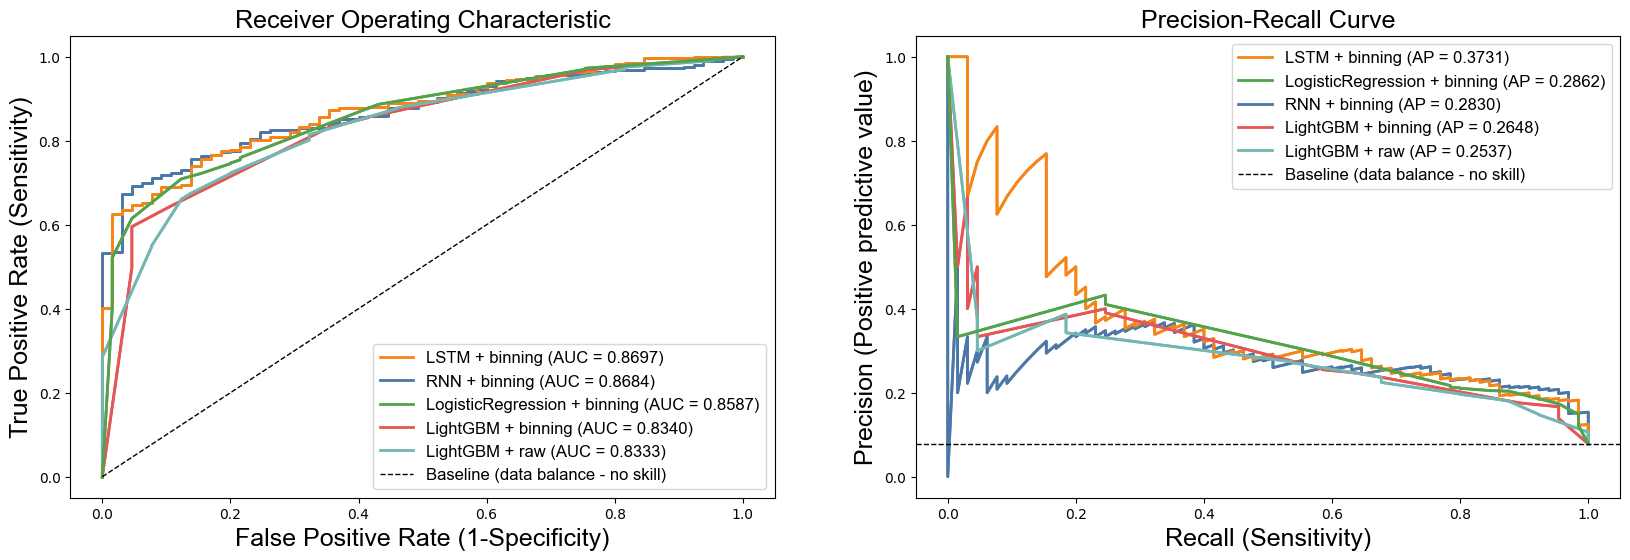

In [14]:
results_df.to_csv('../results/optimized_model_metrics.csv', index=False)
plot_all_metrics(results_df, prediction_data)

In [7]:
cts = auto_train.labels.value_counts()
threshold = cts[1]/len(auto_train)

In [8]:
threshold

0.9098939929328622

In [9]:
test_cts = auto_test.labels.value_counts()
baseline = cts[0]/len(auto_train)

In [10]:
baseline

0.09010600706713781

## Run same script as above but on CDH

In [11]:
def load_data():
    train_data = pd.read_csv(f'{EDW_DIR}/train.csv', index_col=0)
    val_data = pd.read_csv(f'{EDW_DIR}/val.csv', index_col=0)
    test_data = pd.read_csv(f'{CDH_DIR}/full.csv', index_col=0)
    return train_data, val_data, test_data

In [12]:
model_types = ['RNN','LSTM','LightGBM','LogisticRegression']
imputation_methods = ['binning','mean','raw']


hyperparams = {
    'LSTM_binning':{'learning_rate':0.01,'layer_1_size':128,'layer_2_size':64,'batch_size':32,'epochs':100},
    'RNN_binning':{'learning_rate':0.01,'layer_1_size':64,'layer_2_size':16,'batch_size':32,'epochs':100},
    'LightGBM_binning':{'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 127},
    'LightGBM_raw':{'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 127},
    'LogisticRegression_binning':{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
}

# just remove non-optimized models that pass through from the results file
for m in model_types:
    for i in imputation_methods:
        run = f"{m}_{i}"
        if run not in hyperparams.keys():
            if m in ['LSTM','RNN']:
                hyperparams[run] = hyperparams['LSTM_binning']
            elif m == 'LightGBM':
                hyperparams[run] = hyperparams['LightGBM_binning']
            elif m == 'LogisticRegression':
                hyperparams[run] = hyperparams['LogisticRegression_binning']
            else:
                print('Unknown')


print_args = {
    'training':False,
    'model_architecture':False,
    'feature_importance_masking':False,
    'run_feature_importance':False,
    'save_shap':False
}

results_df, prediction_data = run_models_and_collect_results(model_types, imputation_methods, hyperparams, print_args)

Running for model: RNN with imputation method: binning
Threshold 0.9098939929328622
AUC for RNN: 0.842 (0.821, 0.865)
Running for model: RNN with imputation method: mean
Threshold 0.9098939929328622
AUC for RNN: 0.559 (0.512, 0.609)
Running for model: LSTM with imputation method: binning
Threshold 0.9098939929328622
AUC for LSTM: 0.866 (0.848, 0.885)
Running for model: LSTM with imputation method: mean
Threshold 0.9098939929328622
AUC for LSTM: 0.529 (0.481, 0.579)
Running for model: LightGBM with imputation method: binning
Threshold 0.9098939929328622
AUC for LightGBM: 0.833 (0.812, 0.854)
Running for model: LightGBM with imputation method: mean
Threshold 0.9098939929328622
AUC for LightGBM: 0.829 (0.803, 0.853)
Running for model: LightGBM with imputation method: raw
Threshold 0.9098939929328622
AUC for LightGBM: 0.839 (0.815, 0.860)
Running for model: LogisticRegression with imputation method: binning
Threshold 0.9098939929328622
AUC for LogisticRegression: 0.832 (0.809, 0.854)
Runni

In [16]:
results_df = results_df.loc[[0,2,4,6,7],:]

In [17]:
keys_to_keep = ['LSTM_binning', 'RNN_binning', 'LightGBM_binning', 'LightGBM_raw', 'LogisticRegression_binning']

In [18]:
prediction_data = dict(filter(lambda item: item[0] in keys_to_keep, prediction_data.items()))

In [21]:
results_df

,Model_Type,Imputation_Method,AUC,AUPRC,Overall Accuracy,F1 Score Class 0,F1 Score Class 1,Precision Class 0,Precision Class 1,Recall Class 0,Recall Class 1
0,RNN,binning,"0.842 (0.821, 0.865)","0.257 (0.206, 0.317)","0.686 (0.669, 0.703)","0.275 (0.241, 0.310)","0.800 (0.787, 0.812)","0.163 (0.140, 0.187)","0.987 (0.982, 0.992)","0.881 (0.835, 0.927)","0.672 (0.655, 0.690)"
2,LSTM,binning,"0.866 (0.848, 0.885)","0.274 (0.222, 0.332)","0.757 (0.741, 0.773)","0.312 (0.273, 0.350)","0.853 (0.841, 0.863)","0.193 (0.165, 0.221)","0.982 (0.976, 0.988)","0.813 (0.755, 0.867)","0.753 (0.736, 0.769)"
4,LightGBM,binning,"0.833 (0.812, 0.854)","0.216 (0.176, 0.263)","0.636 (0.617, 0.653)","0.256 (0.224, 0.288)","0.759 (0.743, 0.772)","0.149 (0.127, 0.170)","0.991 (0.987, 0.995)","0.927 (0.891, 0.961)","0.614 (0.594, 0.632)"
6,LightGBM,raw,"0.839 (0.815, 0.860)","0.246 (0.199, 0.299)","0.706 (0.689, 0.722)","0.281 (0.245, 0.314)","0.815 (0.802, 0.827)","0.168 (0.143, 0.192)","0.984 (0.979, 0.990)","0.849 (0.800, 0.897)","0.695 (0.677, 0.712)"
7,LogisticRegression,binning,"0.832 (0.809, 0.854)","0.223 (0.179, 0.271)","0.730 (0.714, 0.747)","0.281 (0.245, 0.318)","0.834 (0.822, 0.846)","0.172 (0.146, 0.198)","0.978 (0.972, 0.985)","0.780 (0.721, 0.839)","0.727 (0.710, 0.745)"


In [20]:
results_df.to_csv('../results/optimized_model_metrics_CDH.csv', index=False)

minority_class_proportion 0.06772486772486773


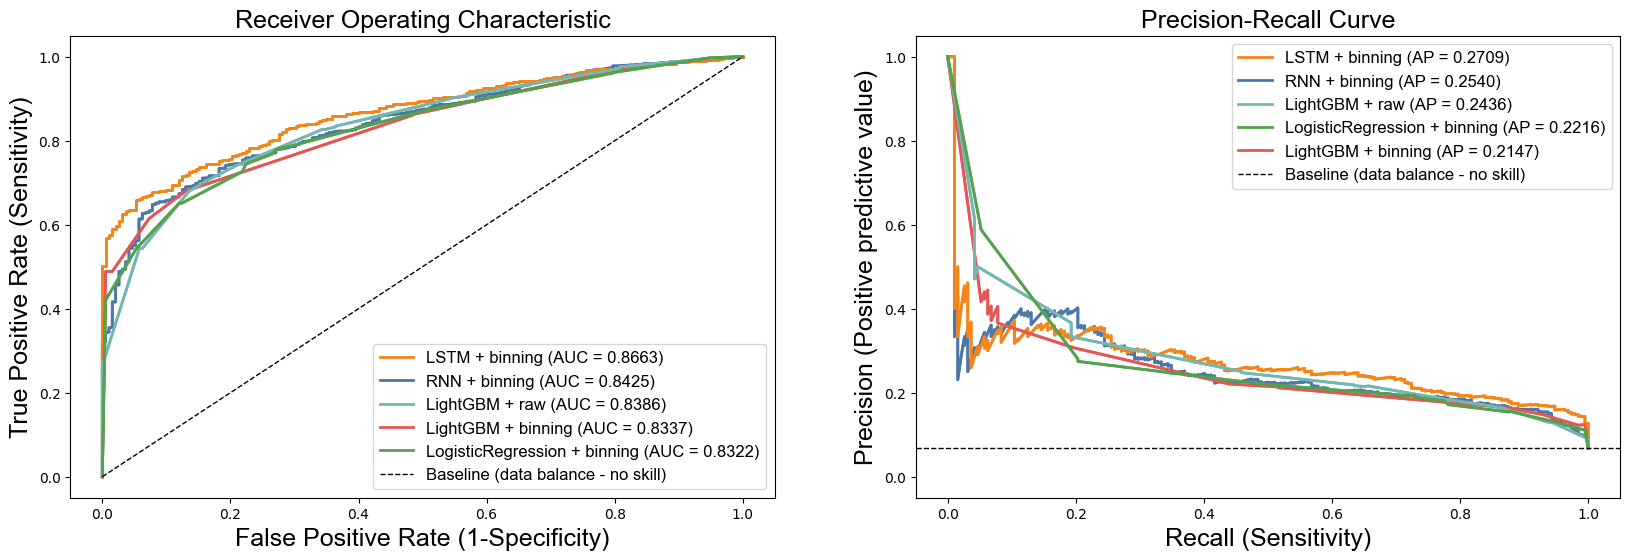

In [19]:
plot_all_metrics(results_df, prediction_data)

## LSTM binning (best model)

### Run on SCRIPT fails

In [52]:
def load_data():
    train_data = pd.read_csv(f'{DATA_DIR}/train.csv', index_col=0)
    val_data = pd.read_csv(f'{DATA_DIR}/val.csv', index_col=0)
    test_data = pd.read_csv(f'{DATA_DIR}/fail.csv', index_col=0)
    return train_data, val_data, test_data

In [53]:
model_types = ['LSTM']
imputation_methods = ['binning']

Running for model: LSTM with imputation method: binning
Threshold 0.9098939929328622
AUC for LSTM: 0.682 (0.599, 0.762)
minority_class_proportion 0.1811320754716981


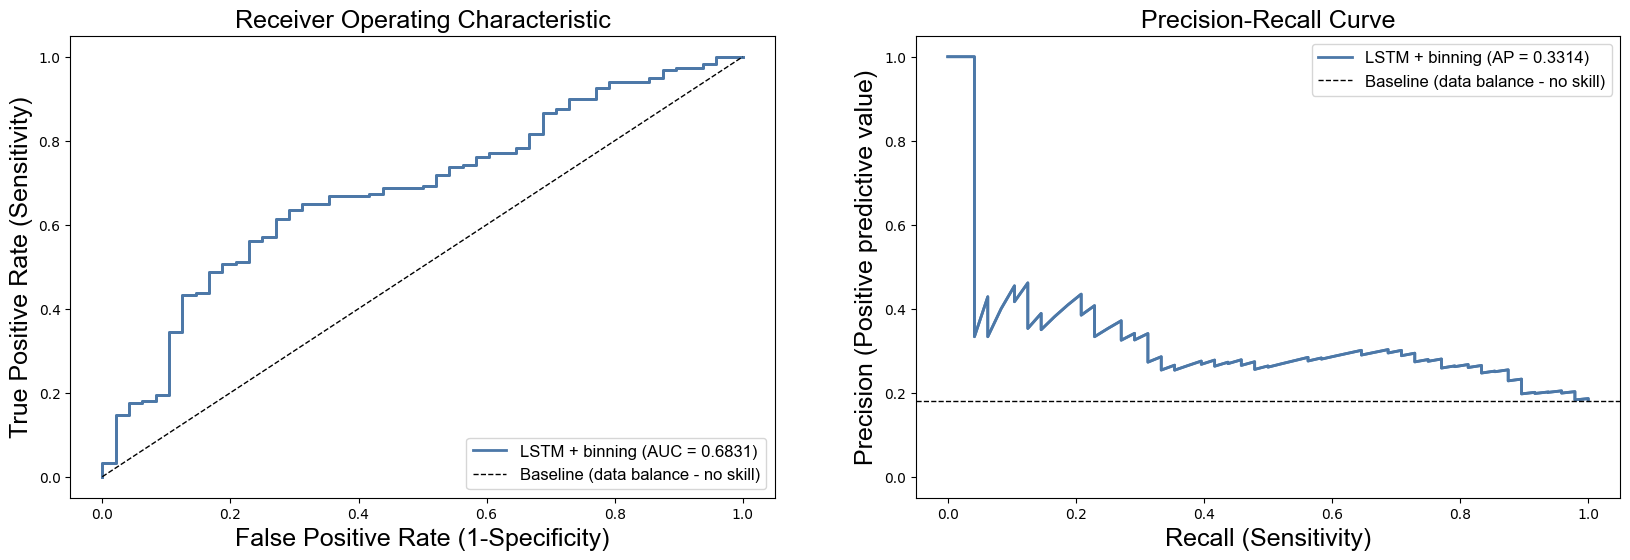

In [54]:
results_df_LSTM_fail, prediction_data_LSTM_fail = run_models_and_collect_results(
    model_types, imputation_methods,hyperparams,print_args
)
plot_all_metrics(results_df_LSTM_fail, prediction_data_LSTM_fail)

In [55]:
script_fail_preds = [1 if x > threshold else 0 for x in prediction_data_LSTM_fail['LSTM_binning']['y_preds_proba']]

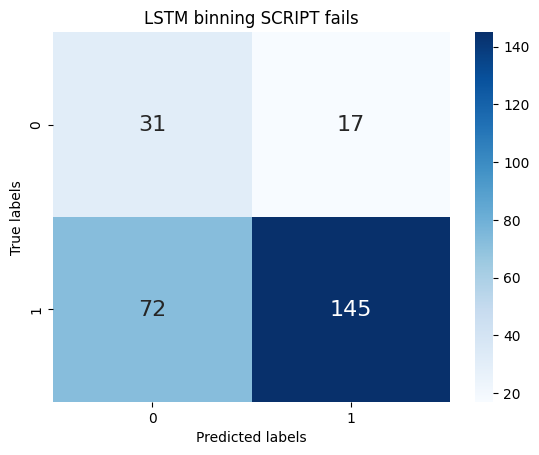

In [56]:
cm = confusion_matrix(auto_fail.labels, script_fail_preds)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('LSTM binning SCRIPT fails')
plt.show()

In [57]:
17/48

0.3541666666666667

### Run on CDH fails

In [21]:
def load_data():
    train_data = auto_train.copy()
    val_data = auto_val.copy()
    test_data = cdh_fail.copy()
    return train_data, val_data, test_data

Running for model: LSTM with imputation method: binning
Threshold 0.9098939929328622


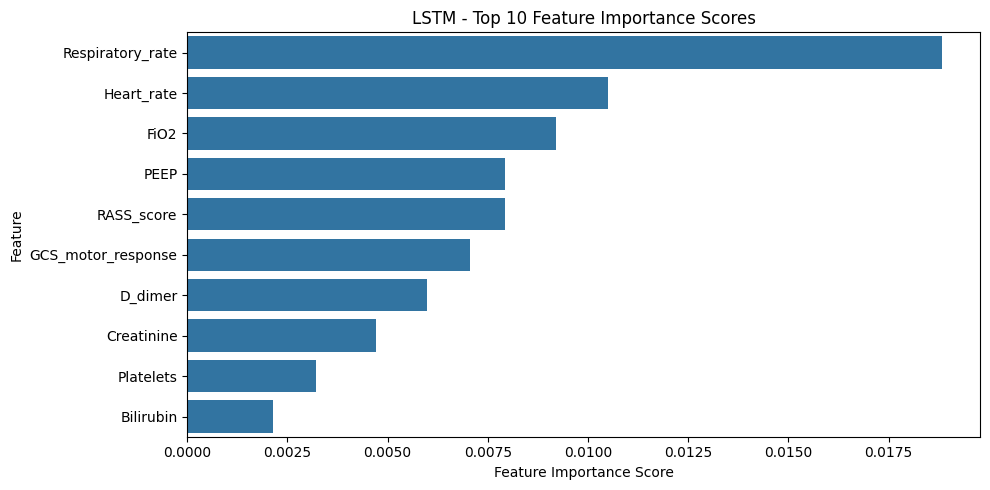

AUC for LSTM: 0.710 (0.605, 0.806)
minority_class_proportion 0.135


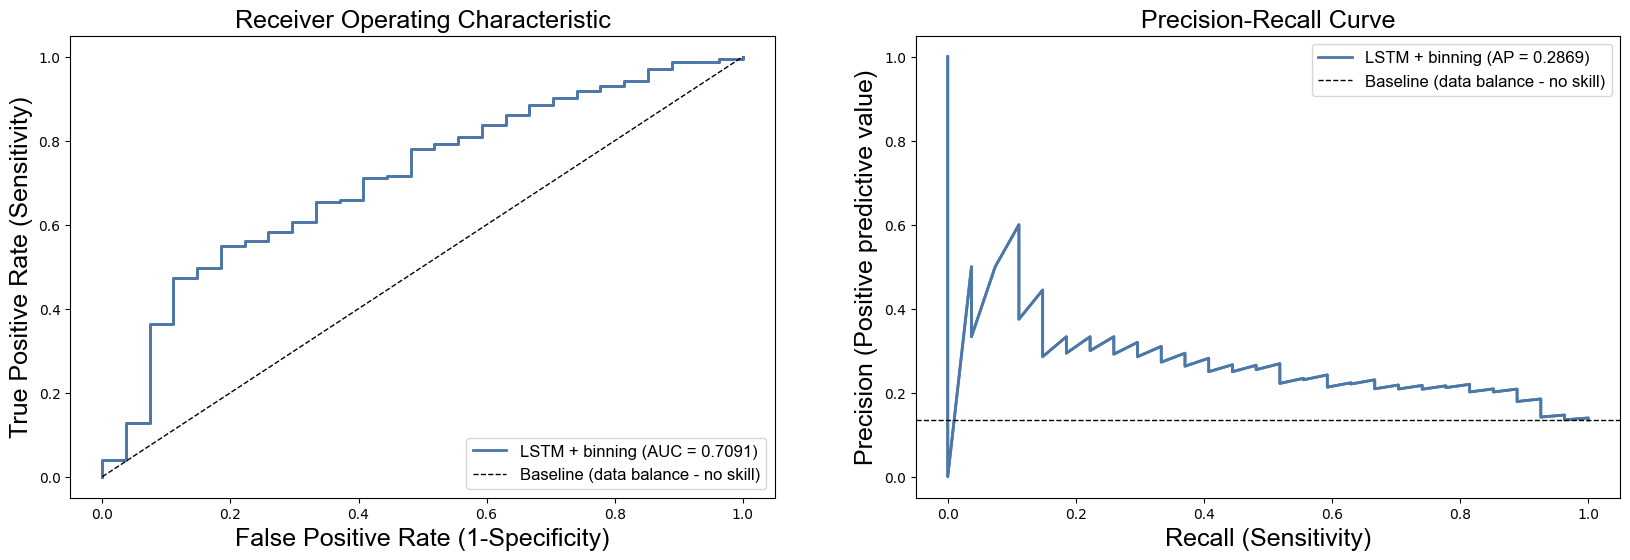

In [22]:
results_df_LSTM_CDH_fail, prediction_data_LSTM_CDH_fail = run_models_and_collect_results(
    model_types, imputation_methods,hyperparams,print_args
)
plot_all_metrics(results_df_LSTM_CDH_fail, prediction_data_LSTM_CDH_fail)

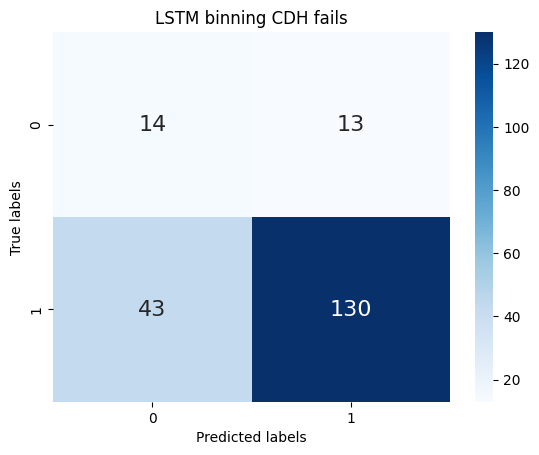

In [23]:
cdh_fail_preds = [1 if x > threshold else 0 for x in prediction_data_LSTM_CDH_fail['LSTM_binning']['y_preds_proba']]
cm = confusion_matrix(cdh_fail.labels, cdh_fail_preds)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('LSTM binning CDH fails')
plt.show()

## Time differences in predicitons

### SCRIPT test set

In [25]:
def load_data():
    train_data = auto_train.copy()
    val_data = auto_val.copy()
    test_data = auto_test.copy()
    return train_data, val_data, test_data

In [26]:
model_types = ['LSTM']
imputation_methods = ['binning']

Running for model: LSTM with imputation method: binning
Threshold 0.9098939929328622


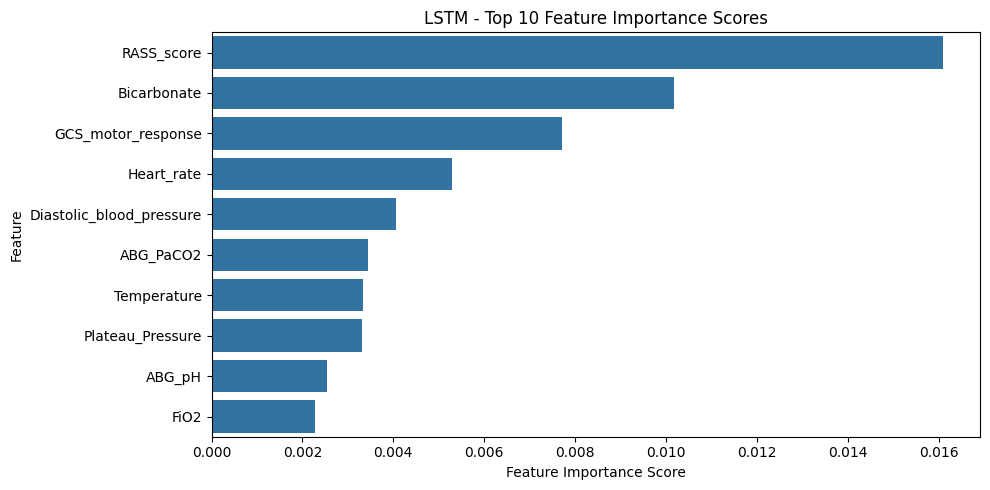

AUC for LSTM: 0.870 (0.834, 0.902)
minority_class_proportion 0.07821901323706378


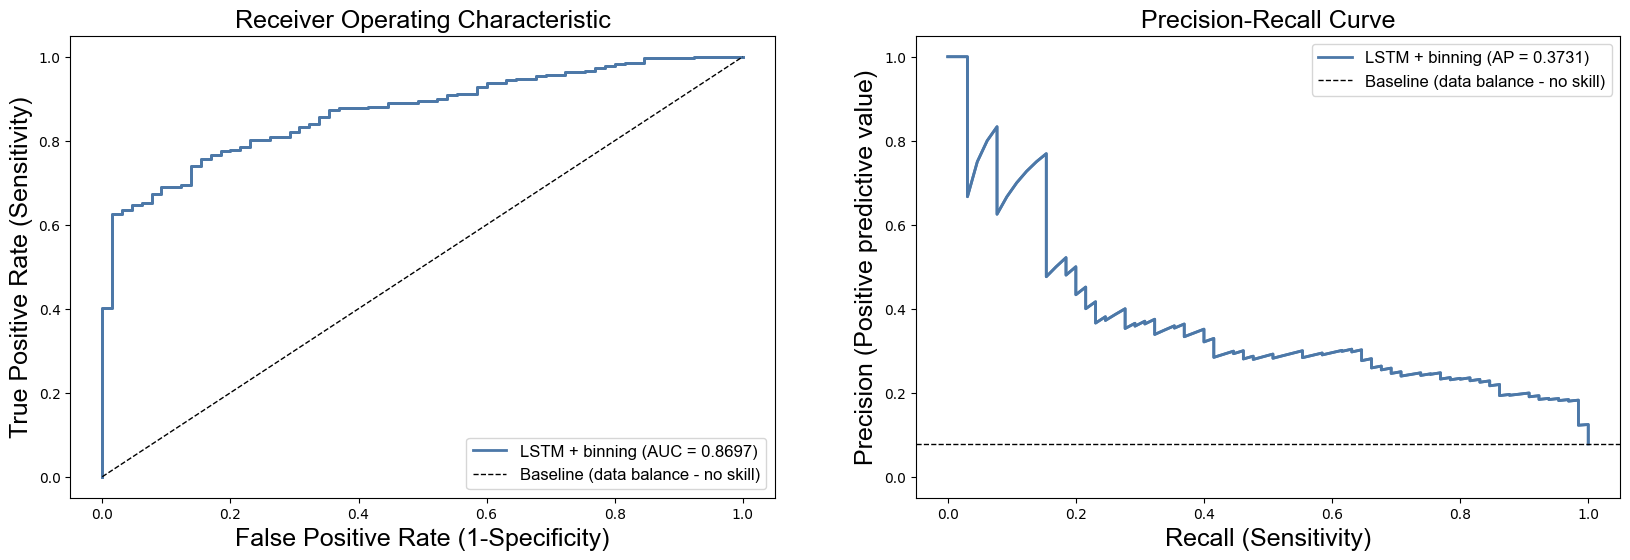

In [28]:
results_df_LSTM_test, prediction_data_LSTM_test = run_models_and_collect_results(
    model_types, imputation_methods, hyperparams, print_args)
plot_all_metrics(results_df_LSTM_test, prediction_data_LSTM_test)

In [60]:
script_test_preds = [1 if x > threshold else 0 for x in prediction_data_LSTM_test['LSTM_binning']['y_preds_proba']]

In [61]:
auto_test_analysis = auto_test.copy()
auto_test_analysis['LSTM_binning_predictions'] = script_test_preds

In [62]:
auto_test_analysis = auto_test_analysis.reset_index().drop(columns='index')

In [63]:
def find_first_zero_last_sequence(lst):
    last_zero_index = None
    found_consecutive_zeros = False
    
    for i in range(len(lst) - 1, -1, -1):
        if lst[i] == 1:
            if found_consecutive_zeros:
                return last_zero_index
        else:
            if not found_consecutive_zeros:
                found_consecutive_zeros = True
            last_zero_index = i
    
    # If there are no non-consecutive sequences of zeros
    if last_zero_index is not None:
        return last_zero_index
    else:
        # If there are only zeros in the list
        return len(lst) - 1

In [64]:
all_deltas = []
first_in_last_seq = []
first = []
for p in auto_test_analysis.Patient_id_2.unique():
    sub = auto_test_analysis[auto_test_analysis.Patient_id_2 == p]
    
    # record only if there was an extubation event and a predicted extubation
    if 0 in list(sub.labels.values) and 0 in list(sub.LSTM_binning_predictions.values):
        saved_sub = sub.copy()
        preds_loc = np.where(sub.LSTM_binning_predictions.values == 0)[0]
        true_extub_loc = np.where(sub.labels.values == 0)[0][0]    
        first.append(true_extub_loc - preds_loc[0])
        for pred_loc in preds_loc:
            all_deltas.append(true_extub_loc - pred_loc)
        
        list_index = find_first_zero_last_sequence(list(sub.LSTM_binning_predictions.values))
        df_index = list(sub.index)[list_index]
        first_in_last_seq.append(true_extub_loc - list_index) 


All early predictions

In [65]:
FIGURES_DIR = '../results'

if not os.path.exists(FIGURES_DIR):
    os.mkdir(FIGURES_DIR)

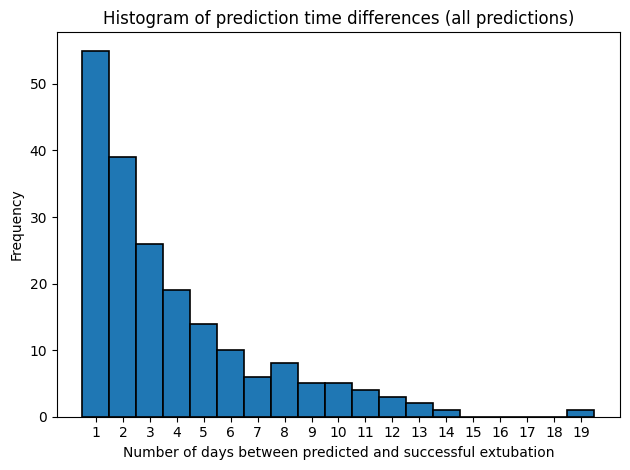

In [66]:
# Set bin edges to be centered on ticks
all_deltas = [x+1 for x in all_deltas]
bin_width = 1
min_edge = min(all_deltas) - bin_width / 2
max_edge = max(all_deltas) + bin_width / 2
bin_edges = np.arange(min_edge, max_edge + bin_width, bin_width)

# Plot histogram with borders
plt.hist(all_deltas, bins=bin_edges, edgecolor='black', linewidth=1.2)
xticks = np.arange(min(all_deltas), max(all_deltas) + bin_width, bin_width)
plt.xticks(xticks)

plt.xlabel('Number of days between predicted and successful extubation')
plt.ylabel('Frequency')
plt.title('Histogram of prediction time differences (all predictions)')
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/time_diff_all_predictions_script.pdf')
# plt.grid(True)
plt.show()


In [67]:
len(all_deltas)

198

Now look at the first prediciton in each sequence

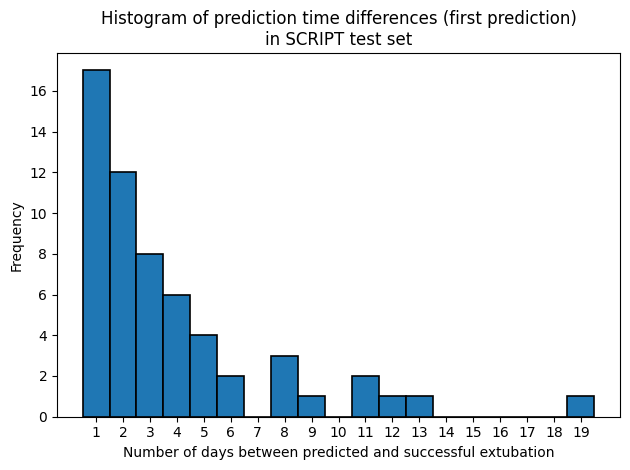

In [68]:
# Set bin edges to be centered on ticks
first = [x+1 for x in first]
bin_width = 1
min_edge = min(first) - bin_width / 2
max_edge = max(first) + bin_width / 2
bin_edges = np.arange(min_edge, max_edge + bin_width, bin_width)

# Plot histogram with borders
plt.hist(first, bins=bin_edges, edgecolor='black', linewidth=1.2)
xticks = np.arange(min(first), max(first) + bin_width, bin_width)
plt.xticks(xticks)

plt.xlabel('Number of days between predicted and successful extubation')
plt.ylabel('Frequency')
plt.title('Histogram of prediction time differences (first prediction)\nin SCRIPT test set')
# plt.grid(True)
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/time_diff_first_predictions_script.pdf')
plt.show()


In [69]:
within_1 = [x for x in first if x == 1]

In [70]:
len(within_1)/len(first)

0.29310344827586204

In [71]:
within_2_two = [x for x in first if x in [1,2]]

In [72]:
len(within_2_two)/len(first)

0.5

In [73]:
within_3 = [x for x in first if x in [1,2,3]]

In [74]:
len(within_3)/len(first)

0.6379310344827587

Get extubation accuracy

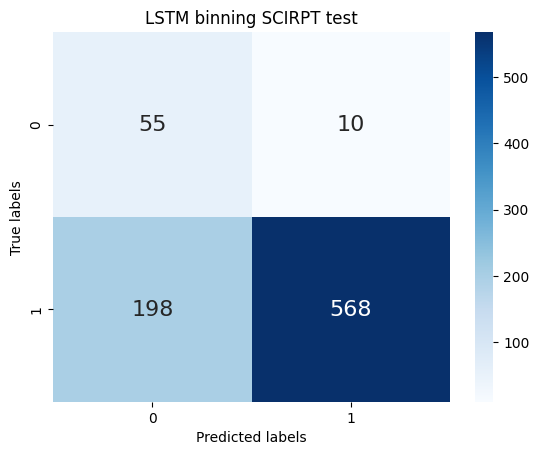

In [97]:
# cdh_fail_preds = [1 if x > threshold else 0 for x in prediction_data_LSTM_CDH_fail['LSTM_binning']['y_preds_proba']]
cm = confusion_matrix(auto_test_analysis.labels, auto_test_analysis.LSTM_binning_predictions)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('LSTM binning SCRIPT test')
plt.show()

### Report the same for the CDH test set

In [45]:
def load_data():
    train_data = auto_train.copy()
    val_data = auto_val.copy()
    test_data = cdh_full.copy()
    return train_data, val_data, test_data

Running for model: LSTM with imputation method: binning
Threshold 0.9098939929328622


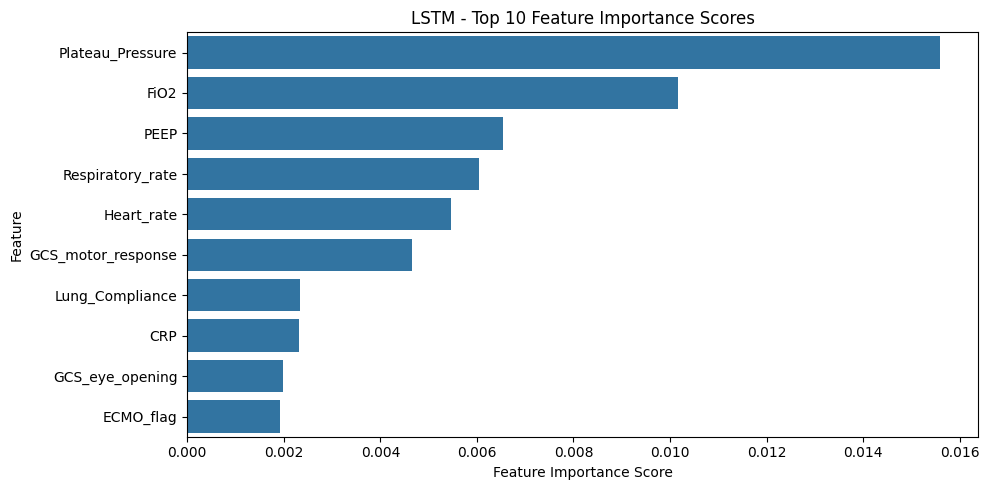

AUC for LSTM: 0.866 (0.848, 0.885)
minority_class_proportion 0.06772486772486773


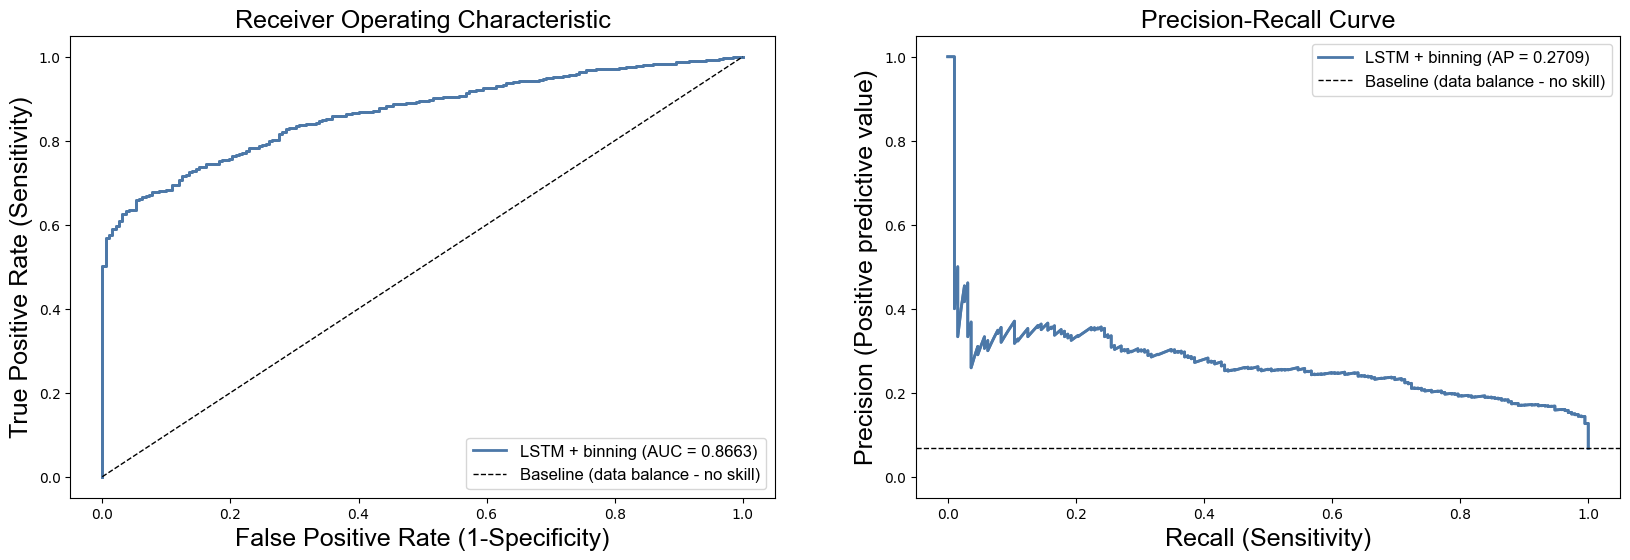

In [46]:
results_df_LSTM_CDH, prediction_data_LSTM_CDH = run_models_and_collect_results(
    model_types, imputation_methods, hyperparams, print_args)
plot_all_metrics(results_df_LSTM_CDH, prediction_data_LSTM_CDH)

In [75]:
cdh_test_preds = [1 if x > threshold else 0 for x in prediction_data_LSTM_CDH['LSTM_binning']['y_preds_proba']]

In [76]:
cdh_test_analysis = cdh_full.copy()
cdh_test_analysis['LSTM_binning_predictions'] = cdh_test_preds

In [77]:
cdh_test_analysis = cdh_test_analysis.reset_index().drop(columns='index')

In [78]:
all_deltas = []
first_in_last_seq = []
first = []
for p in cdh_test_analysis.Patient_id_2.unique():
    sub = cdh_test_analysis[cdh_test_analysis.Patient_id_2 == p]
    
    # record only if there was an extubation event and a predicted extubation
    if 0 in list(sub.labels.values) and 0 in list(sub.LSTM_binning_predictions.values):
        saved_sub = sub.copy()
        preds_loc = np.where(sub.LSTM_binning_predictions.values == 0)[0]
        true_extub_loc = np.where(sub.labels.values == 0)[0][0]    
        first.append(true_extub_loc - preds_loc[0])
        for pred_loc in preds_loc:
            all_deltas.append(true_extub_loc - pred_loc)
        
        list_index = find_first_zero_last_sequence(list(sub.LSTM_binning_predictions.values))
        df_index = list(sub.index)[list_index]
        first_in_last_seq.append(true_extub_loc - list_index) 

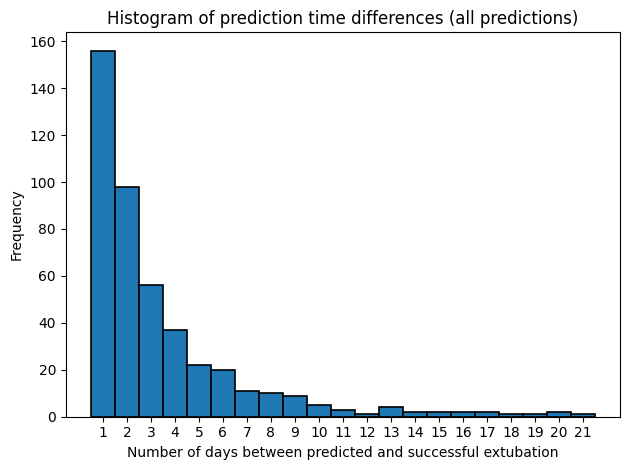

In [79]:
# Set bin edges to be centered on ticks
all_deltas = [x+1 for x in all_deltas]
bin_width = 1
min_edge = min(all_deltas) - bin_width / 2
max_edge = max(all_deltas) + bin_width / 2
bin_edges = np.arange(min_edge, max_edge + bin_width, bin_width)

# Plot histogram with borders
plt.hist(all_deltas, bins=bin_edges, edgecolor='black', linewidth=1.2)
xticks = np.arange(min(all_deltas), max(all_deltas) + bin_width, bin_width)
plt.xticks(xticks)

plt.xlabel('Number of days between predicted and successful extubation')
plt.ylabel('Frequency')
plt.title('Histogram of prediction time differences (all predictions)')
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/time_diff_all_predictions_cdh.pdf')
# plt.grid(True)
plt.show()

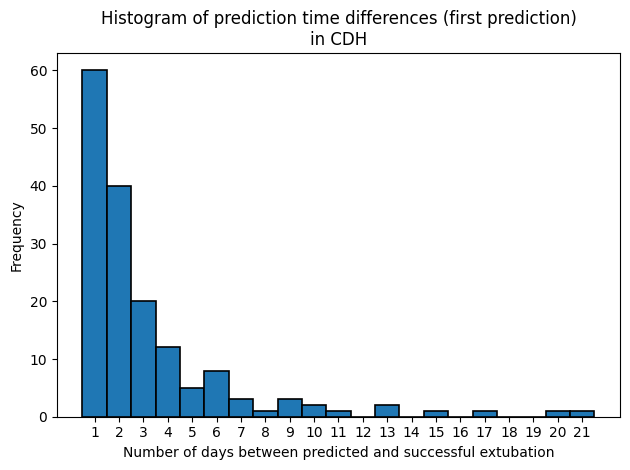

In [80]:
# Set bin edges to be centered on ticks
first = [x+1 for x in first]
bin_width = 1
min_edge = min(first) - bin_width / 2
max_edge = max(first) + bin_width / 2
bin_edges = np.arange(min_edge, max_edge + bin_width, bin_width)

# Plot histogram with borders
plt.hist(first, bins=bin_edges, edgecolor='black', linewidth=1.2)
xticks = np.arange(min(first), max(first) + bin_width, bin_width)
plt.xticks(xticks)

plt.xlabel('Number of days between predicted and successful extubation')
plt.ylabel('Frequency')
plt.title('Histogram of prediction time differences (first prediction)\nin CDH')
# plt.grid(True)
plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/time_diff_first_predictions_cdh.pdf')
plt.show()

In [81]:
within_1 = [x for x in first if x == 1]

In [82]:
len(within_1)/len(first)

0.37267080745341613

In [83]:
within_2_two = [x for x in first if x in [1,2]]

In [84]:
len(within_2_two)/len(first)

0.6211180124223602

In [85]:
within_3 = [x for x in first if x in [1,2,3]]

In [86]:
len(within_3)/len(first)

0.7453416149068323

## Get LR binning performance on CDH

In [28]:
def load_data():
    train_data = auto_train.copy()
    val_data = auto_val.copy()
    test_data = cdh_full.copy()
    return train_data, val_data, test_data

In [24]:
model_types = ['LogisticRegression'] 
hyperparams = { 
    'LR':{'C':0.1,'penalty':'l1','solver':'liblinear'}
}

Running for model: LogisticRegression with imputation method: binning
Threshold 0.9098939929328622
AUC for LogisticRegression: 0.832 (0.809, 0.854)
minority_class_proportion 0.06772486772486773


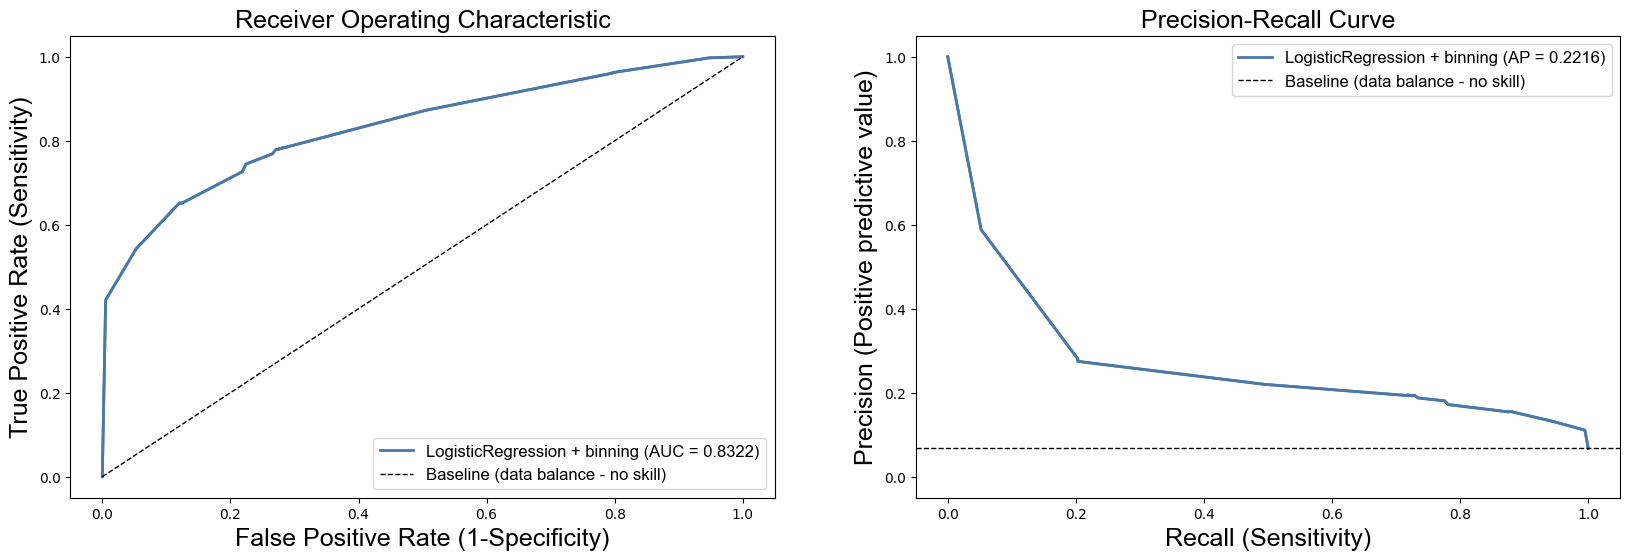

In [29]:
results_df_LR_CDH, prediction_data_LR_CDH = run_models_and_collect_results(
    model_types, imputation_methods, hyperparams, print_args)
plot_all_metrics(results_df_LR_CDH, prediction_data_LR_CDH)

## Get shapley for XGBoost

In [12]:
def load_data():
    train_data = auto_train.copy()
    val_data = auto_val.copy()
    test_data = auto_test.copy()
    return train_data, val_data, test_data

In [13]:
model_types = ['LogisticRegression'] 
hyperparams = {}
model_types = ['XGBoost']
imputation_methods = ['raw']
print_args = {
    'training':False,
    'model_architecture':False,
    'feature_importance_masking':False,
    'run_feature_importance':True,
    'save_shap':True
}

Running for model: XGBoost with imputation method: raw
Threshold 0.9098939929328622


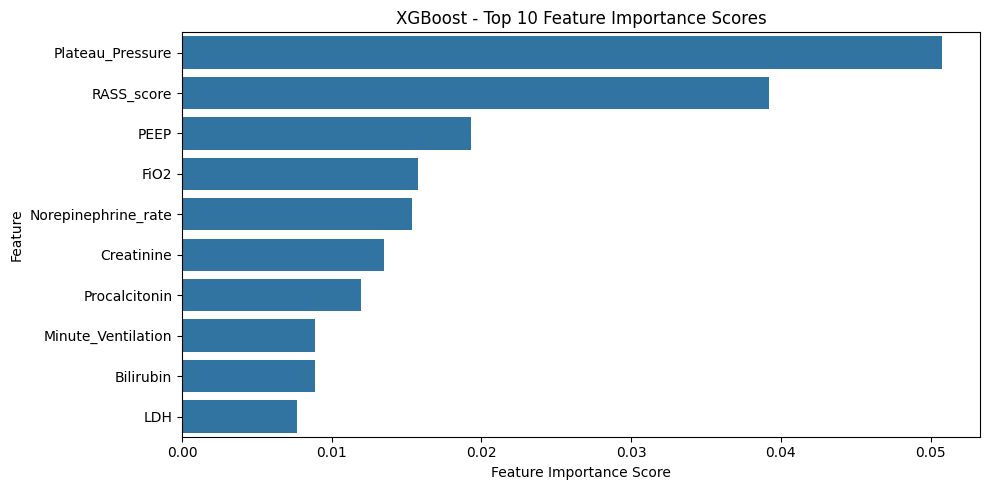

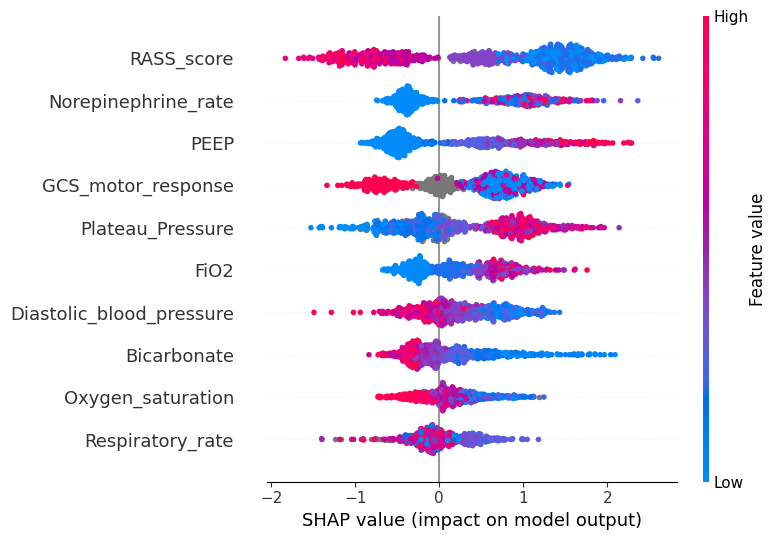

AUC for XGBoost: 0.798 (0.755, 0.835)
minority_class_proportion 0.07821901323706378


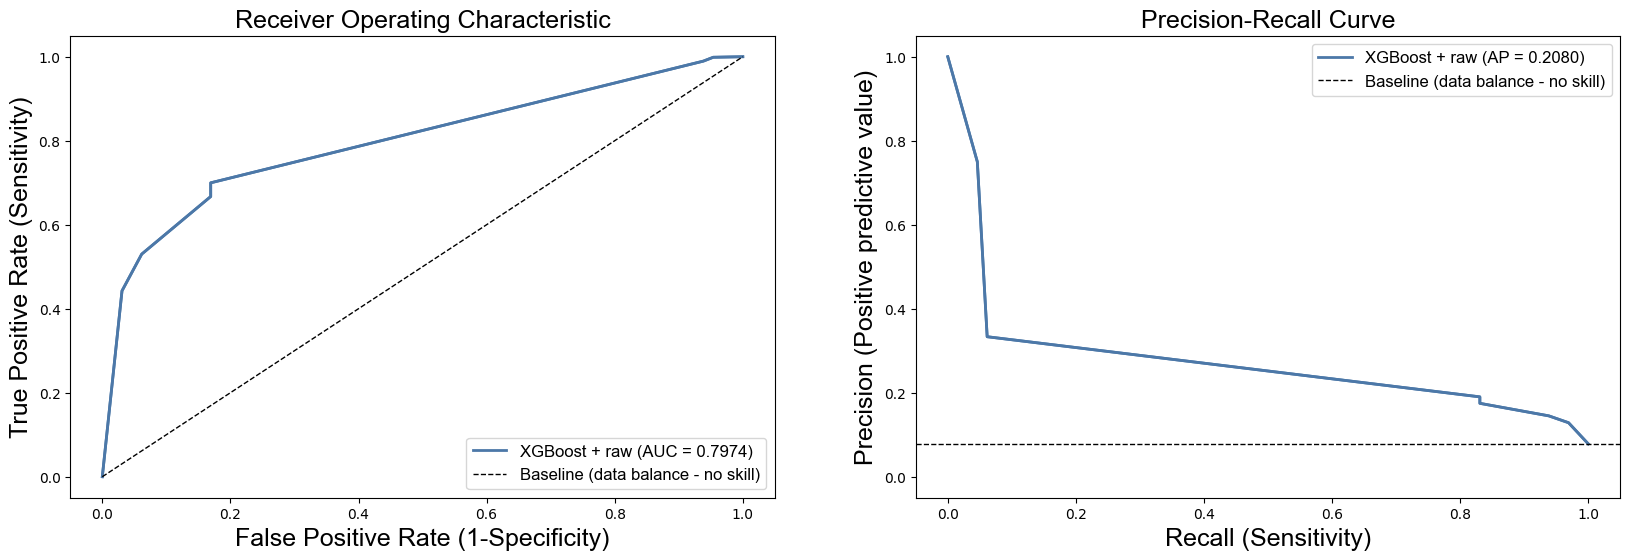

In [14]:
results_df_LR_CDH, prediction_data_LR_CDH = run_models_and_collect_results(
    model_types, imputation_methods, hyperparams, print_args)
plot_all_metrics(results_df_LR_CDH, prediction_data_LR_CDH)

## Check Thomas autoML

In [4]:
results = pd.read_csv(f'{DATA_DIR}/../mljar_supervised_run_by_thomas/v2_auto_trimmed/output/results_extubation_on_test_set.csv')

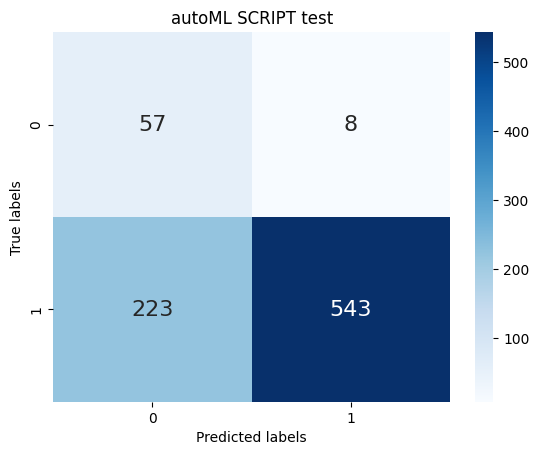

In [13]:
automl_preds = [1 if x > threshold else 0 for x in results.pred_proba_1]
cm = confusion_matrix(results.observed, automl_preds)
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('autoML SCRIPT test')
plt.show()

In [16]:
roc_auc_score(results.observed, results.pred_proba_1)

0.8693713597107852